This script serves as a sanity check on the representation level.
The different data representations are used to classify call types as a proof of sufficient information.

DFA (PAFs), simple MLPs (LFCCs) and CNNs (spectrograms) are used to classify the different call types.

In [27]:
import pandas as pd
import numpy as np
import json
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [3]:
RANDOM_SEED = 42
random.seed(42)
np.random.seed(42)

In [4]:
calls_df = pd.read_csv('features_and_spectrograms.csv')
calls_df['log_padded_spectrogram'] = calls_df['log_padded_spectrogram'].apply(lambda x: np.array(json.loads(x)))

In [5]:
print(len(calls_df[calls_df.isna().any(axis=1)]))
calls_df = calls_df.dropna()
calls_df = calls_df[calls_df['call_type'] != 'unknown']
calls_df.info()

811
<class 'pandas.core.frame.DataFrame'>
Index: 6323 entries, 0 to 7282
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   track_ID                6323 non-null   object 
 1   clip_ID                 6323 non-null   object 
 2   goose_ID                6323 non-null   object 
 3   call_type               6323 non-null   object 
 4   waveform                6323 non-null   object 
 5   sr                      6323 non-null   int64  
 6   filepath                6323 non-null   object 
 7   lfccs                   6323 non-null   object 
 8   peak                    6323 non-null   float64
 9   duration                6323 non-null   float64
 10  log_padded_spectrogram  6323 non-null   object 
 11  log_padded_lfccs        6323 non-null   object 
 12  f0mean                  6323 non-null   float64
 13  f0range                 6323 non-null   float64
 14  f0min                   6323 non-null   f

In [6]:
le = LabelEncoder()
le.fit(calls_df["call_type"])
calls_df["encoded_call_type"] = le.transform(calls_df["call_type"])

## DFA

In [7]:
features_list = ["duration", "f0mean", "f0range", "f0min", "f0max", "f0std_dev", "mean_slope", "f0_q1", "f0_q2", "f0_q3", "hnr", "centr_s", "skew_s", "kurt_s", "std_s", "centr_t", "skew_t", "kurt_t", "std_t", "avg_f_form1"]

In [8]:
X = calls_df[features_list].values
y = calls_df['call_type'].values

In [9]:
X_scaled = StandardScaler().fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_SEED)

In [31]:
qda = QDA(reg_param=0.2)
qda.fit(X_train, y_train)

/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(reg_param=0.2)

In [33]:
y_pred = qda.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

       alarm       0.00      0.00      0.00        14
     contact       0.46      0.21      0.28       228
   departure       0.77      0.83      0.80       214
    distance       0.92      0.91      0.91        98
 recruitment       0.72      0.87      0.79       651
     triumph       0.26      0.12      0.16        60

    accuracy                           0.70      1265
   macro avg       0.52      0.49      0.49      1265
weighted avg       0.66      0.70      0.67      1265

Accuracy: 0.7027667984189724


In [39]:
lda = LDA(solver="lsqr", shrinkage=0, n_components=1)
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=1, shrinkage=0, solver='lsqr')

In [40]:
y_pred = lda.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

coef_df = pd.DataFrame(lda.coef_, columns=features_list, index=lda.classes_)
print("Feature coefficients per class:")
print(coef_df)

              precision    recall  f1-score   support

       alarm       0.05      0.07      0.06        14
     contact       0.59      0.07      0.13       228
   departure       0.84      0.79      0.82       214
    distance       0.97      0.91      0.94        98
 recruitment       0.70      0.95      0.81       651
     triumph       0.31      0.22      0.25        60

    accuracy                           0.72      1265
   macro avg       0.58      0.50      0.50      1265
weighted avg       0.70      0.72      0.66      1265

Accuracy: 0.71699604743083
Feature coefficients per class:
             duration    f0mean   f0range     f0min     f0max  f0std_dev  \
alarm       -1.287448  9.308294  0.680101 -1.167731 -0.325774  -0.992151   
contact     -0.888282  0.446316 -0.995798  0.216377 -0.623857   0.972619   
departure    1.502519 -1.138024  2.067075 -0.830374  1.013987  -2.066850   
distance     3.836731 -5.979485  1.934937  0.949214  2.221850  -2.357568   
recruitment -0.826

In [37]:
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],  # Test different solvers
    'shrinkage': ['auto', 0.0, 0.1, 0.5, 1.0],  # Only applicable to lsqr/eigen
    'n_components': [1, 2, 3]  # Number of components to keep
}

# GridSearchCV for LDA
grid_search = GridSearchCV(LDA(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_lda = grid_search.best_estimator_
y_pred = best_lda.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Best Parameters: {'n_components': 1, 'shrinkage': 0.0, 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.6789241270921055
Test Accuracy: 0.71699604743083


/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
78 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

In [30]:
param_grid = {'reg_param': [0.0, 0.1, 0.2, 0.5, 1.0]}

# GridSearchCV for QDA
grid_search = GridSearchCV(QDA(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_qda = grid_search.best_estimator_
y_pred = best_qda.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/len

Best Parameters: {'reg_param': 0.2}
Best Cross-Validation Accuracy: 0.67832909145643
Test Accuracy: 0.7027667984189724


/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [13]:
abs_coef = coef_df.abs().mean(axis=0)
print("Feature Importance Ranking:")
print(abs_coef.sort_values(ascending=False))

Feature Importance Ranking:
centr_t        4.346632
f0mean         2.994396
duration       1.700156
f0_q3          1.394945
f0std_dev      1.248302
f0range        1.088663
f0_q1          0.869533
f0_q2          0.834594
f0max          0.800182
std_s          0.713223
kurt_t         0.694141
skew_t         0.675752
centr_s        0.657112
skew_s         0.631294
avg_f_form1    0.551747
f0min          0.537699
mean_slope     0.471325
std_t          0.380202
hnr            0.334370
kurt_s         0.181882
dtype: float64


In [14]:
# simulate chance level
true_labels = calls_df["call_type"]
class_probs = true_labels.value_counts(normalize=True)
random_predictions = np.random.choice(class_probs.index, size=len(true_labels), p=class_probs.values)

# Calculate accuracy for random guessing
random_accuracy = accuracy_score(true_labels, random_predictions)

print("Empirical Chance Level (Random Guessing):", random_accuracy)


Empirical Chance Level (Random Guessing): 0.3098212873635932


In [15]:
# Permutation test to evaluate the significance of LDA model's accuracy
def permutation_test(X, y, lda_model, num_permutations=100, test_size=0.2, random_state=RANDOM_SEED):

    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Train LDA and calculate the accuracy
    lda_model.fit(X_train, y_train)
    real_accuracy = accuracy_score(y_test, lda_model.predict(X_test))

    # List to store accuracies from shuffled labels
    permuted_accuracies = []

    # Perform permutation test
    for _ in range(num_permutations):
        # Shuffle labels
        shuffled_y = np.random.permutation(y)

        # Train LDA on shuffled labels
        lda_model.fit(X_train, shuffled_y[:len(y_train)])
        permuted_accuracy = accuracy_score(y_test, lda_model.predict(X_test))

        # Append permuted accuracy to list
        permuted_accuracies.append(permuted_accuracy)

    # Calculate p-value
    permuted_accuracies = np.array(permuted_accuracies)
    p_value = np.mean(permuted_accuracies >= real_accuracy)

    return real_accuracy, permuted_accuracies, p_value

In [16]:
real_accuracy, permuted_accuracies, p_value = permutation_test(X_scaled, y, LDA())

print("Real Accuracy:", real_accuracy)
print("P-value:", p_value)

Real Accuracy: 0.71699604743083
P-value: 0.0


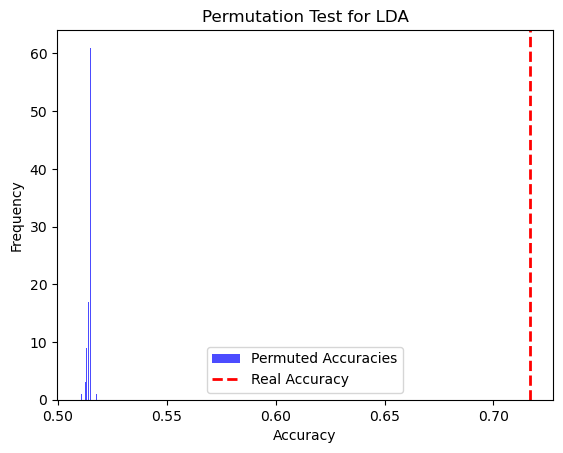

In [17]:
# Plot histogram of permuted accuracies
plt.hist(permuted_accuracies, bins=20, alpha=0.7, color='blue', label='Permuted Accuracies')

plt.axvline(real_accuracy, color='red', linestyle='dashed', linewidth=2, label='Real Accuracy')

plt.title("Permutation Test for LDA")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## MLP

## CNN